<a href="https://colab.research.google.com/github/EmaanBashir/A-B-Test-Analysis-for-Foodtech-Company/blob/main/Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import scipy.stats as stats

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/hackathon/DATASET.csv')
df.head()

,event_id,session_id,user_id,variation,platform,datetime_event,event_type,final_order_status,shop_id
0,63527610,6391574,762832,2,Android,2024-11-30 16:23:46.391133804,entry_to_shop,successful,8531.0
1,12446736,6391574,762832,2,Android,2024-11-30 16:26:16.875713965,order_paid,successful,8531.0
2,90232698,6391574,762832,2,Android,2024-11-30 16:50:44.827088753,order_finished,successful,8531.0
3,74183469,9246026,762832,2,Android,2024-11-29 13:21:28.729203894,reload_the_page,NaN,6186.0
4,16360628,9246026,762832,2,Android,2024-11-29 13:21:35.213637901,entry_to_shop,NaN,6186.0


In [4]:
# Display basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326921 entries, 0 to 326920
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   event_id            326921 non-null  int64  
 1   session_id          326921 non-null  int64  
 2   user_id             326921 non-null  int64  
 3   variation           326921 non-null  int64  
 4   platform            326921 non-null  object 
 5   datetime_event      326921 non-null  object 
 6   event_type          326921 non-null  object 
 7   final_order_status  170632 non-null  object 
 8   shop_id             315842 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 22.4+ MB


In [5]:
# Check for missing values
print(df.isnull().sum())

event_id                   0
session_id                 0
user_id                    0
variation                  0
platform                   0
datetime_event             0
event_type                 0
final_order_status    156289
shop_id                11079
dtype: int64


In [6]:
# Check for duplicates
df.duplicated().sum()

0

In [8]:
# Convert datetime column to proper format
df["datetime_event"] = pd.to_datetime(df["datetime_event"])

In [9]:
# Count of users in each variation
user_counts = df.groupby("variation")["user_id"].nunique()
print("User count per variation:\n", user_counts)

User count per variation:
 variation
1    65000
2    35000
Name: user_id, dtype: int64


In [10]:
# Check unique values in key columns
df["event_type"].value_counts()


,count
event_type,
entry_to_shop,168215
reload_the_page,53870
order_paid,52418
order_finished,52418


In [11]:
# Number of unique users for each event type
df.groupby('event_type')["user_id"].nunique()

,user_id
event_type,
entry_to_shop,96293
order_finished,42338
order_paid,42338
reload_the_page,43388


In [12]:
# Number of unique users in each group for each event type
df.groupby(['variation', 'event_type'])["user_id"].nunique()

variation  event_type     
1          entry_to_shop      62581
           order_finished     27568
           order_paid         27568
           reload_the_page    28171
2          entry_to_shop      33712
           order_finished     14770
           order_paid         14770
           reload_the_page    15217
Name: user_id, dtype: int64

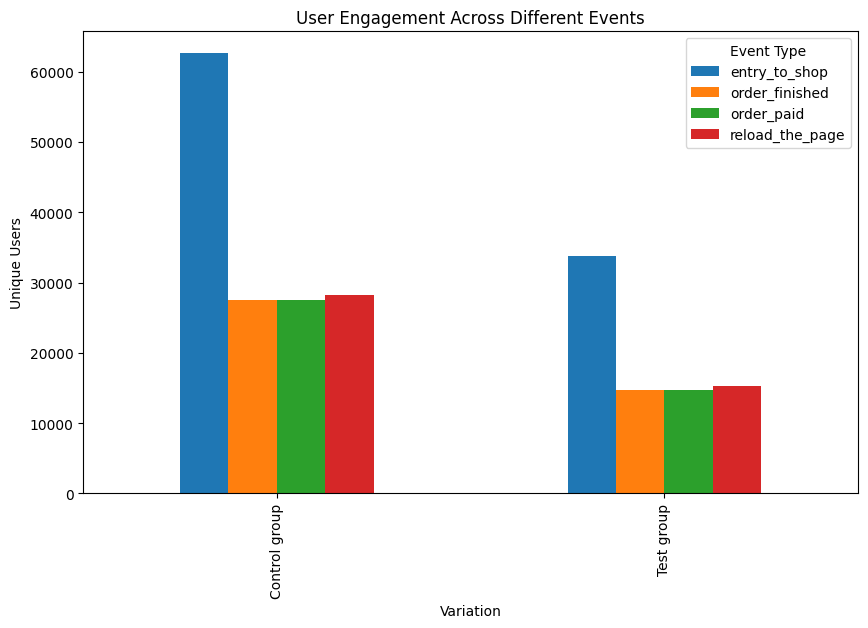

In [13]:
# User engagement analysis
engagement = df.groupby(["variation", "event_type"])["user_id"].nunique().unstack()
engagement.index = engagement.index.map({1: "Control group", 2: "Test group"})

# Visualization - User engagement
engagement.plot(kind="bar", figsize=(10, 6))
plt.xlabel("Variation")
plt.ylabel("Unique Users")
plt.title("User Engagement Across Different Events")
plt.legend(title="Event Type")
plt.show()


In [15]:
df["final_order_status"].value_counts()

,count
final_order_status,
successful,146035
cancelled,17199
refunded_after_delivery,7398


In [16]:
### Descriptive Statistics

# User Level Conversion rate calculation
orders = df[df["event_type"] == "order_paid"]
conversion_rates = orders.groupby("variation")["user_id"].nunique() / user_counts
print("Conversion rates:\n", conversion_rates)


Conversion rates:
 variation
1    0.424123
2    0.422000
Name: user_id, dtype: float64


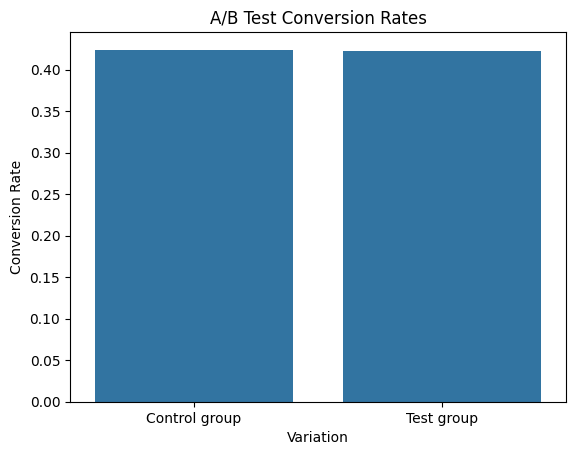

In [17]:
# Plot conversion rates
sns.barplot(x=conversion_rates.index.map({1: "Control group", 2: "Test group"}), y=conversion_rates.values)
plt.xlabel("Variation")
plt.ylabel("Conversion Rate")
plt.title("A/B Test Conversion Rates")
plt.show()

In [20]:
### Hypothesis Testing

# Null Hypothesis (H₀): The conversion rate is independent of the variation (i.e., larger images do not impact order rates).
# Alternative Hypothesis (H₁): The conversion rate depends on the variation (i.e., larger images significantly affect order rates).

# Count users who made a payment (order_paid)
orders = df[df["event_type"] == "order_paid"].groupby("variation")["user_id"].nunique()

# Create contingency table
control_total, test_total = user_counts[1], user_counts[2]
control_orders, test_orders = orders.get(1, 0), orders.get(2, 0)

contingency_table = [[control_orders, control_total - control_orders],
                     [test_orders, test_total - test_orders]]

print(contingency_table)

# Chi-Square Test
chi2, p, _, _ = stats.chi2_contingency(contingency_table)
print(f"Chi-Square Test: χ²={chi2:.2f}, p-value={p:.4f}") # p-value > 0.05 → Fail to reject H₀ → No significant impact

[[27568, 37432], [14770, 20230]]
Chi-Square Test: χ²=0.41, p-value=0.5213


In [18]:
# Variation 1 is control and variation 2 is test
control_group = df[df['variation'] == 1]
test_group = df[df['variation'] == 2]

# Compare average number of reload_the_page events between the two groups
control_reload_avg = control_group[control_group['event_type'] == 'reload_the_page'].shape[0] / control_group['user_id'].nunique()
test_reload_avg = test_group[test_group['event_type'] == 'reload_the_page'].shape[0] / test_group['user_id'].nunique()

print(f"Control Group Average Reloads: {control_reload_avg:.2f}")
print(f"Test Group Average Reloads: {test_reload_avg:.2f}")

Control Group Average Reloads: 0.54
Test Group Average Reloads: 0.54


User distribution by platform:
 platform   Android    iOS
variation                
1            45454  19546
2            24541  10459


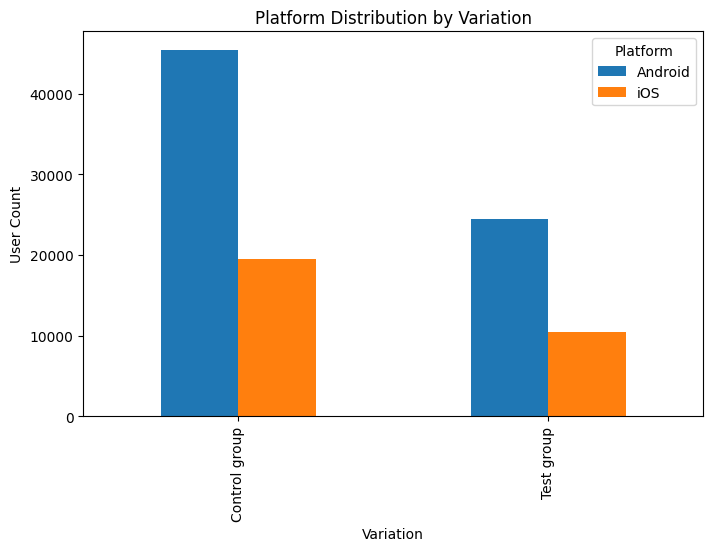

In [23]:
# Platform-wise distribution
platform_dist = df.groupby(["variation", "platform"])["user_id"].nunique().unstack()
print("User distribution by platform:\n", platform_dist)

platform_dist.index = platform_dist.index.map({1: "Control group", 2: "Test group"})

# Visualization - Platform usage
platform_dist.plot(kind="bar", figsize=(8, 5))
plt.xlabel("Variation")
plt.ylabel("User Count")
plt.title("Platform Distribution by Variation")
plt.legend(title="Platform")
plt.show()

Daily order counts:
 variation        1     2
day_of_week             
Friday       10205  5407
Monday        3673  1894
Saturday      7553  4091
Sunday          86    52
Thursday      4581  2394
Tuesday       4062  2200
Wednesday     3980  2240


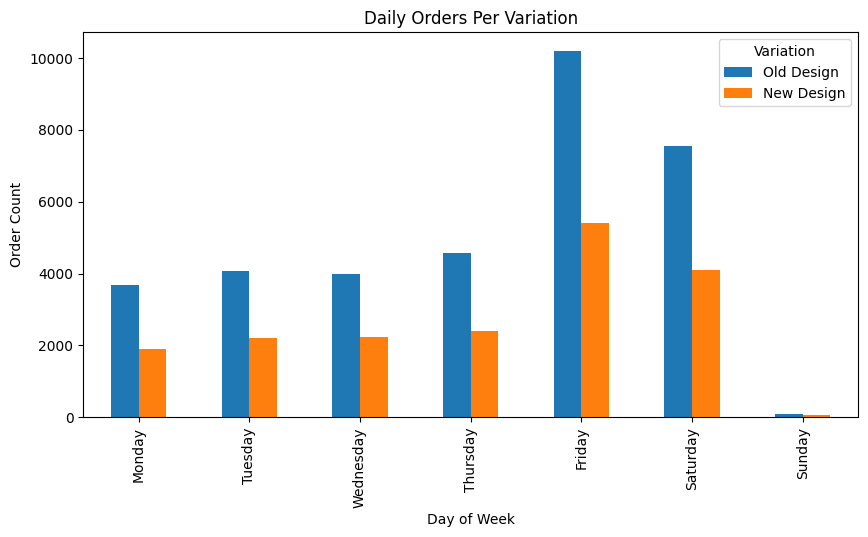

Hourly order counts:
 variation       1     2
hour_of_day            
0             460   236
7               2     2
8               5     1
9              15     6
10             37    27
11            117    74
12            323   200
13            719   412
14           1512   872
15           2689  1482
16           3966  2114
17           4935  2753
18           5517  2849
19           5069  2668
20           3911  2074
21           2628  1290
22           1501   839
23            734   379


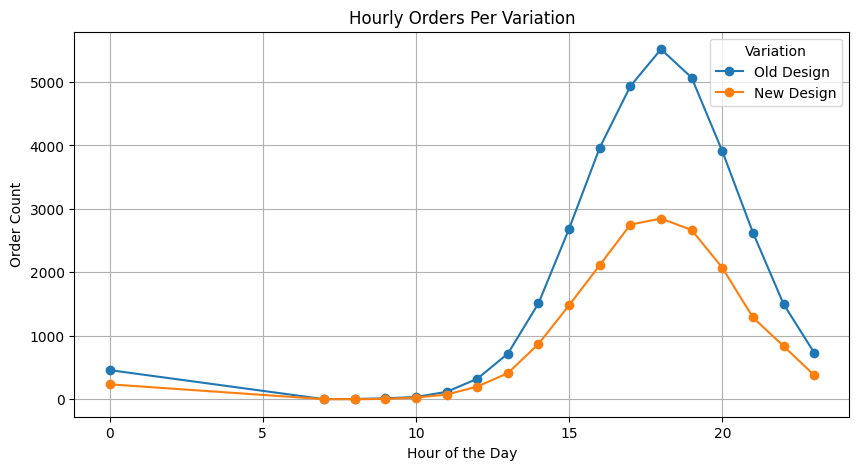

Peak ordering hours per variation:
 variation
1    18
2    18
dtype: int32


In [26]:
# Extract day of week and hour
df["day_of_week"] = df["datetime_event"].dt.day_name()
df["hour_of_day"] = df["datetime_event"].dt.hour

# Check order counts per day for each variation
orders = df[df["event_type"] == "order_paid"]
daily_orders = orders.groupby(["day_of_week", "variation"])["user_id"].count().unstack()
print("Daily order counts:\n", daily_orders)

# Sort by weekday order (Monday-Sunday)
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
daily_orders = daily_orders.reindex(weekday_order)

# Visualization - Orders by Day of Week
daily_orders.plot(kind="bar", figsize=(10, 5))
plt.xlabel("Day of Week")
plt.ylabel("Order Count")
plt.title("Daily Orders Per Variation")
plt.legend(title="Variation", labels=["Old Design", "New Design"])
plt.show()

# Orders per hour
hourly_orders = orders.groupby(["hour_of_day", "variation"])["user_id"].count().unstack()
print("Hourly order counts:\n", hourly_orders)

# Visualization - Orders by Hour
hourly_orders.plot(kind="line", marker="o", figsize=(10, 5))
plt.xlabel("Hour of the Day")
plt.ylabel("Order Count")
plt.title("Hourly Orders Per Variation")
plt.legend(title="Variation", labels=["Old Design", "New Design"])
plt.grid()
plt.show()

# Peak order hours
peak_hours = hourly_orders.idxmax()
print("Peak ordering hours per variation:\n", peak_hours)


   variation platform  user_id_total  user_id_orders  conversion_rate
0          1  Android          45454           18782         0.413209
1          1      iOS          19546            8786         0.449504
2          2  Android          24541           10033         0.408826
3          2      iOS          10459            4737         0.452911
    variation day_of_week  user_id_total  user_id_orders  conversion_rate
0           1      Friday          28206            9552         0.338651
1           1      Monday          11697            3573         0.305463
2           1    Saturday          21771            7168         0.329245
3           1      Sunday            152              86         0.565789
4           1    Thursday          13945            4457         0.319613
5           1     Tuesday          12838            3966         0.308927
6           1   Wednesday          12865            3871         0.300894
7           2      Friday          14990            5053  

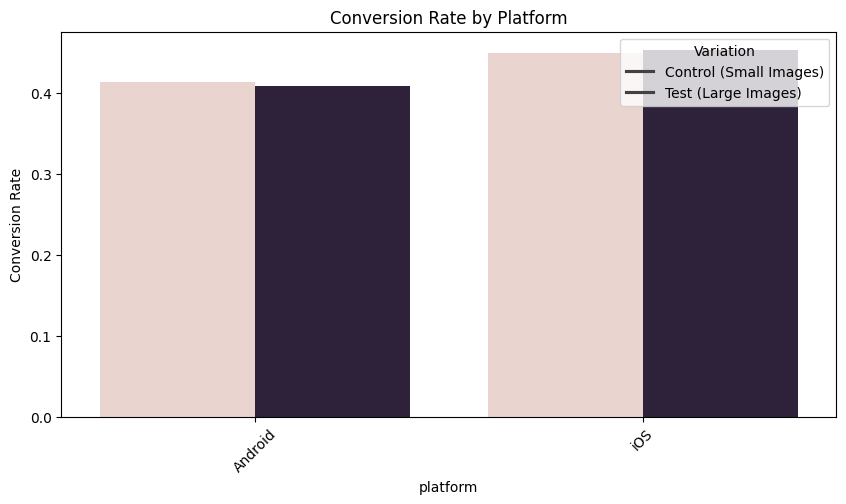

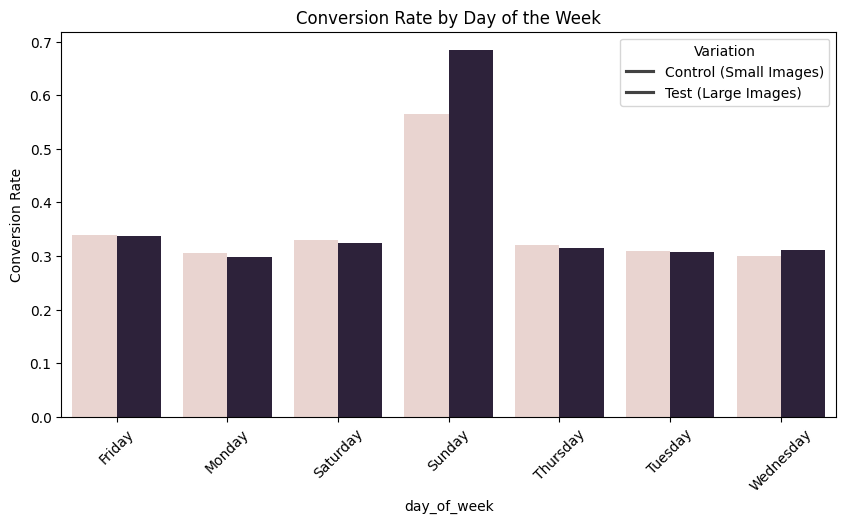

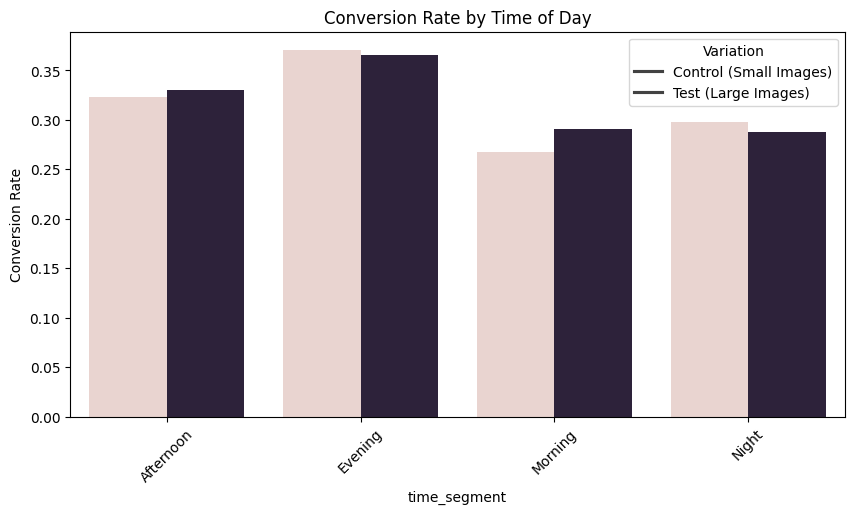


📊 Chi-Square Test by Platform:
platform: Android
Chi-Square Test: χ²=1.25, p-value=0.2643
----------------------------------------
platform: iOS
Chi-Square Test: χ²=0.31, p-value=0.5802
----------------------------------------

📊 Chi-Square Test by Day of the Week:
day_of_week: Friday
Chi-Square Test: χ²=0.10, p-value=0.7523
----------------------------------------
day_of_week: Monday
Chi-Square Test: χ²=1.28, p-value=0.2581
----------------------------------------
day_of_week: Saturday
Chi-Square Test: χ²=0.57, p-value=0.4493
----------------------------------------
day_of_week: Sunday
Chi-Square Test: χ²=2.50, p-value=0.1139
----------------------------------------
day_of_week: Thursday
Chi-Square Test: χ²=0.67, p-value=0.4128
----------------------------------------
day_of_week: Tuesday
Chi-Square Test: χ²=0.07, p-value=0.7912
----------------------------------------
day_of_week: Wednesday
Chi-Square Test: χ²=1.93, p-value=0.1644
----------------------------------------

📊 Chi-Squa

In [24]:
### Segmentation Analysis

# Extract day of the week and time of the day
df["day_of_week"] = df["datetime_event"].dt.day_name()
df["hour"] = df["datetime_event"].dt.hour

# Define time segments
def get_time_segment(hour):
    if 5 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 21:
        return "Evening"
    else:
        return "Night"

df["time_segment"] = df["hour"].apply(get_time_segment)

# Calculate conversion rates by segment
def conversion_rate_by_segment(segment_col):
    segment_data = df.groupby(["variation", segment_col])["user_id"].nunique().reset_index()
    orders = df[df["event_type"] == "order_paid"].groupby(["variation", segment_col])["user_id"].nunique().reset_index()

    segment_conversion = segment_data.merge(orders, on=["variation", segment_col], how="left", suffixes=("_total", "_orders"))
    segment_conversion["conversion_rate"] = segment_conversion["user_id_orders"] / segment_conversion["user_id_total"]

    return segment_conversion.fillna(0)

# Segmentation: Platform (iOS vs. Android)
platform_conversion = conversion_rate_by_segment("platform")
print(platform_conversion)

# Segmentation: Day of the Week
day_conversion = conversion_rate_by_segment("day_of_week")
print(day_conversion)

# Segmentation: Time of Day
time_conversion = conversion_rate_by_segment("time_segment")
print(time_conversion)

# Plot conversion rates by segment
def plot_conversion_rates(data, segment_col, title):
    plt.figure(figsize=(10, 5))
    sns.barplot(x=segment_col, y="conversion_rate", hue="variation", data=data)
    plt.title(title)
    plt.ylabel("Conversion Rate")
    plt.xlabel(segment_col)
    plt.xticks(rotation=45)
    plt.legend(title="Variation", labels=["Control (Small Images)", "Test (Large Images)"])
    plt.show()

# Visualizations
plot_conversion_rates(platform_conversion, "platform", "Conversion Rate by Platform")
plot_conversion_rates(day_conversion, "day_of_week", "Conversion Rate by Day of the Week")
plot_conversion_rates(time_conversion, "time_segment", "Conversion Rate by Time of Day")

# Statistical Tests for Each Segment
def chi_square_test(data, segment_col):
    for segment in data[segment_col].unique():
        segment_data = data[data[segment_col] == segment]
        if len(segment_data) < 2:
            continue
        contingency_table = [
            [segment_data.iloc[0]["user_id_orders"], segment_data.iloc[0]["user_id_total"] - segment_data.iloc[0]["user_id_orders"]],
            [segment_data.iloc[1]["user_id_orders"], segment_data.iloc[1]["user_id_total"] - segment_data.iloc[1]["user_id_orders"]]
        ]
        chi2, p, _, _ = stats.chi2_contingency(contingency_table)
        print(f"{segment_col}: {segment}")
        print(f"Chi-Square Test: χ²={chi2:.2f}, p-value={p:.4f}")
        print("-" * 40)

print("\n📊 Chi-Square Test by Platform:")
chi_square_test(platform_conversion, "platform")

print("\n📊 Chi-Square Test by Day of the Week:")
chi_square_test(day_conversion, "day_of_week")

print("\n📊 Chi-Square Test by Time of Day:")
chi_square_test(time_conversion, "time_segment")

# 1️) Platform Effect (iOS vs. Android)

# Does the impact of larger images vary by platform?
# Example: If Android users convert more than iOS users, UX differences could be a factor.
# 2️) Day of the Week

# Are certain days of the week more affected by the variation?
# Example: Larger images might increase conversion more on weekends when users browse more casually.
# 3️) Time of Day

# Do conversions differ in the morning vs. evening?
# Example: Maybe users make impulse purchases more at night, regardless of the image size.

In [65]:
# Analyze order success rate
order_success_rate = df[df['event_type'] == 'order_finished']['final_order_status'].value_counts(normalize=True)
print("Order Success Rate:\n", order_success_rate)

Order Success Rate:
 final_order_status
successful                 0.855775
cancelled                  0.101129
refunded_after_delivery    0.043096
Name: proportion, dtype: float64


final_order_status  cancelled  refunded_after_delivery  successful
variation                                                         
1                        3391                     2088       28661
2                        1910                      171       16197


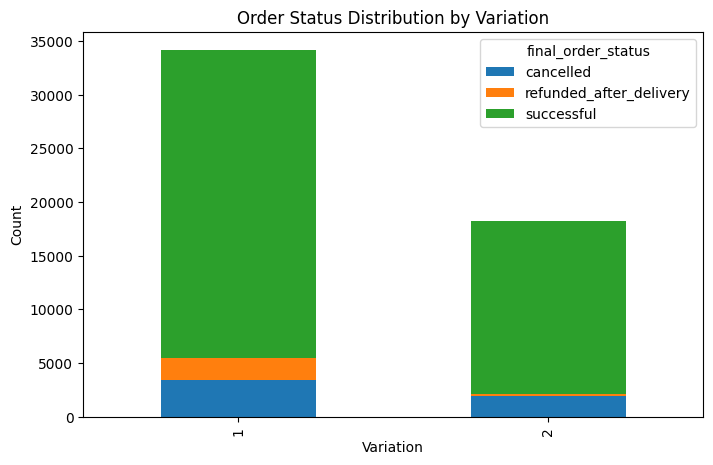

In [40]:
# Order status analysis
order_status_counts = df[df["event_type"] == "order_finished"].groupby(["variation", "final_order_status"])["user_id"].count().unstack()
print(order_status_counts)

# Plot order status distribution
order_status_counts.plot(kind="bar", stacked=True, figsize=(8, 5))
plt.xlabel("Variation")
plt.ylabel("Count")
plt.title("Order Status Distribution by Variation")
plt.show()

In [32]:
contingency_table = [
    [segment_data.iloc[0]["user_id_orders"], segment_data.iloc[0]["user_id_total"] - segment_data.iloc[0]["user_id_orders"]],
    [segment_data.iloc[1]["user_id_orders"], segment_data.iloc[1]["user_id_total"] - segment_data.iloc[1]["user_id_orders"]]
]
chi2, p, _, _ = stats.chi2_contingency(contingency_table)
print(f"{segment_col}: {segment}")
print(f"Chi-Square Test: χ²={chi2:.2f}, p-value={p:.4f}")


variation
1    6.115993
2    0.935551
dtype: float64
Chi-Square Test: χ²=0.00, p-value=1.0000


In [43]:
order_status_counts["not_refunded"] = order_status_counts.sum(axis = 1) - order_status_counts["refunded_after_delivery"]
contingency_table = [
            [order_status_counts.iloc[0]["refunded_after_delivery"], order_status_counts.iloc[0]["not_refunded"]],
                        [order_status_counts.iloc[1]["refunded_after_delivery"], order_status_counts.iloc[1]["not_refunded"]]
        ]

chi2, p, _, _ = stats.chi2_contingency(contingency_table)
print(f"Chi-Square Test: χ²={chi2:.2f}, p-value={p:.4f}")

Chi-Square Test: χ²=784.36, p-value=0.0000


In [44]:
contingency_table

[[2088, 64104], [171, 36214]]